# 事前準備

In [1]:
from itertools import product
from typing import Optional

from IPython.display import display, Markdown
from joblib import Memory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
ANOMALY_LABEL = -1
NORMAL_LABEL = 1

In [3]:
pd.set_option("display.max.rows", None)

In [63]:
# 元の生データをダウンロードするには、事前に下記のステップを完了させてください
# 1. Kaggle のアカウントを作成
# 2. Kaggle にログインし、https://www.kaggle.com/settings/account の API - Create New Token から kaggle.json をダウンロード
# 3. kaggle.json を ~/.kaggle/kaggle.json に配置

# !kaggle datasets download nphantawee/pump-sensor-data

In [59]:
# def resample(df, rule = '10T'):
#     sensors_resampled = df.drop(columns='machine_status').resample(rule).mean()
#     status_resampled = df[['machine_status']].resample(rule).agg(
#         lambda x: "BROKEN" if "BROKEN" in x.tolist() else
#             "RECOVERING" if "RECOVERING" in x.tolist() else
#             "NORMAL"
#     )
#     resampled_df = pd.concat([sensors_resampled, status_resampled], axis=1)
#     return resampled_df

In [60]:
# def drop_highly_correlated_columns(df):
#     melted_corr = (
#         df[df.describe().columns]
#         .corr()
#         .where(lambda df: np.triu(np.ones(df.shape), k=1).astype(bool))  # 上三角部分のみ残す
#         .reset_index()
#         .melt(id_vars="index")
#         .where(lambda df: df["index"] != df["variable"])
#         .where(lambda df: df["value"] > 0.7)
#         .dropna()
#         .sort_values(["index", "variable"])
#     )
#     drop_columns = sorted(list(set(melted_corr["variable"])))
#     return df.drop(columns=drop_columns)

In [61]:
# def rename_sensors(df):
#     sensor_columns = df.filter(regex="^sensor_").columns.tolist()
#     rename_dict = {orig: f"s{i:02d}" for i, orig in enumerate(sensor_columns)}
#     df = df.rename(columns=rename_dict)
#     return df

In [62]:
# # 生データから本notebookで使用する用のデータに変換し、保存
# df = (
#     pd.read_csv(
#         "pump-sensor-data.zip",
#         parse_dates=["timestamp"],
#         index_col="timestamp"
#     )
#     .drop(columns=["Unnamed: 0", "sensor_15"])
#     .pipe(resample)
#     .pipe(drop_highly_correlated_columns)
#     .pipe(rename_sensors)
# )
# df.to_csv("sensor.csv")

# データセットの読み込み

In [9]:
def add_stabilization_status(df):
    # RECOVERINGからNORMALに変わるポイント
    recovering_to_normal = (
        (df['machine_status'] == "NORMAL")
        & (df['machine_status'].shift(1) == "RECOVERING")
    )
    recovering_to_normal_index = df.index[recovering_to_normal]

    # NORMALから将来のx分間の s00 の std が初めて 0.05未満 かつ mean が
    # 2.2以上になる ポイントを見つけ、それまでを STABILIZATION フェーズとする
    for i in range(len(recovering_to_normal_index)):
        idx = recovering_to_normal_index[i]
        print(idx)
        minutes = 0
        add_minutes = 60
        window_size = 360
        limit = (
            recovering_to_normal_index[i+1]
            if i != len(recovering_to_normal_index) - 1
            else df.index.max()
        )
        while(True):
            begin = idx + pd.Timedelta(minutes=minutes)
            end = idx + pd.Timedelta(minutes=minutes + window_size)
            std = df.loc[begin:end, "s00"].std()
            mean = df.loc[begin:end, "s00"].mean()
            if std < 0.05 and 2.2 <= mean:
                df.loc[idx:end, "machine_status"] = 'STABILIZATION'
                break
            minutes += add_minutes

            if limit < end:
                df.loc[idx:end, "machine_status"] = 'STABILIZATION'
                break

    return df


In [10]:
df = (
    pd.read_csv(
        "sensor.csv",
        parse_dates=["timestamp"],
        index_col="timestamp"
    )
    .bfill()
    .pipe(add_stabilization_status)
)

2018-04-13 13:40:00
2018-04-20 04:30:00
2018-05-20 01:20:00
2018-05-25 10:40:00
2018-07-04 18:00:00
2018-07-08 01:00:00
2018-07-25 15:20:00


In [11]:
df.shape

(22032, 17)

In [12]:
df.columns

Index(['s00', 's01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 'machine_status'],
      dtype='object')

In [13]:
df.head()

,s00,s01,s02,s03,s04,s05,s06,s07,s08,s09,s10,s11,s12,s13,s14,s15,machine_status
timestamp,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.454966,47.131073,1.666368,420.09408,447.91395,164.16404,93.344712,42.057289,31.901041,74.687495,38.888888,62.615740,38.715276,166.98494,67.795142,201.64930,NORMAL
2018-04-01 00:10:00,2.455064,48.315972,1.680008,419.89171,456.04422,163.66479,89.701563,45.260414,32.343747,75.078122,41.637731,53.096062,39.409722,214.23612,73.119211,199.79745,NORMAL
2018-04-01 00:20:00,2.452899,48.897568,1.823943,419.96173,449.19264,167.25610,91.697104,45.208330,32.291665,67.265623,39.033564,50.000000,40.248843,206.65509,94.733809,209.49074,NORMAL
2018-04-01 00:30:00,2.456441,48.559026,1.760167,419.92536,443.67406,171.30731,87.932910,42.682289,34.270830,66.510415,36.660878,46.701389,40.277777,209.34606,92.563662,222.51157,NORMAL
2018-04-01 00:40:00,2.453391,49.118921,1.952894,420.20299,451.84222,170.76836,89.452807,43.229164,33.229163,68.307289,37.123841,45.341436,37.876157,210.32985,71.672455,217.04283,NORMAL


In [14]:
df["machine_status"].value_counts(dropna=False)

machine_status
NORMAL           19797
RECOVERING        1447
STABILIZATION      781
BROKEN               7
Name: count, dtype: int64

In [15]:
def check_machine_status_transition(df: pd.DataFrame):
    def print_duration(current, last_changed_at, status):
        print(f"{current}: {status:13s} lasted {current - last_changed_at}")

    status = df["machine_status"].iloc[0]
    last_changed_at = df.index[0]
    for i, rows in df.iterrows():
        if status != rows["machine_status"]:
            print_duration(i, last_changed_at, status)
            last_changed_at = i
        status = rows["machine_status"]
    print_duration(i, last_changed_at, status)

In [16]:
check_machine_status_transition(df)

2018-04-12 21:50:00: NORMAL        lasted 11 days 21:50:00
2018-04-12 22:00:00: BROKEN        lasted 0 days 00:10:00
2018-04-13 13:40:00: RECOVERING    lasted 0 days 15:40:00
2018-04-15 08:50:00: STABILIZATION lasted 1 days 19:10:00
2018-04-18 00:30:00: NORMAL        lasted 2 days 15:40:00
2018-04-18 00:40:00: BROKEN        lasted 0 days 00:10:00
2018-04-20 04:30:00: RECOVERING    lasted 2 days 03:50:00
2018-04-20 22:40:00: STABILIZATION lasted 0 days 18:10:00
2018-05-19 03:10:00: NORMAL        lasted 28 days 04:30:00
2018-05-19 03:20:00: BROKEN        lasted 0 days 00:10:00
2018-05-20 01:20:00: RECOVERING    lasted 0 days 22:00:00
2018-05-20 17:30:00: STABILIZATION lasted 0 days 16:10:00
2018-05-25 00:30:00: NORMAL        lasted 4 days 07:00:00
2018-05-25 00:40:00: BROKEN        lasted 0 days 00:10:00
2018-05-25 10:40:00: RECOVERING    lasted 0 days 10:00:00
2018-05-25 21:50:00: STABILIZATION lasted 0 days 11:10:00
2018-06-28 22:00:00: NORMAL        lasted 34 days 00:10:00
2018-06-28 

In [17]:
df.columns

Index(['s00', 's01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 'machine_status'],
      dtype='object')

In [18]:
df.describe().loc["count"]

s00    22032.0
s01    22032.0
s02    22032.0
s03    22032.0
s04    22032.0
s05    22032.0
s06    22032.0
s07    22032.0
s08    22032.0
s09    22032.0
s10    22032.0
s11    22032.0
s12    22032.0
s13    22032.0
s14    22032.0
s15    22032.0
Name: count, dtype: float64

In [19]:
df.head()

,s00,s01,s02,s03,s04,s05,s06,s07,s08,s09,s10,s11,s12,s13,s14,s15,machine_status
timestamp,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.454966,47.131073,1.666368,420.09408,447.91395,164.16404,93.344712,42.057289,31.901041,74.687495,38.888888,62.615740,38.715276,166.98494,67.795142,201.64930,NORMAL
2018-04-01 00:10:00,2.455064,48.315972,1.680008,419.89171,456.04422,163.66479,89.701563,45.260414,32.343747,75.078122,41.637731,53.096062,39.409722,214.23612,73.119211,199.79745,NORMAL
2018-04-01 00:20:00,2.452899,48.897568,1.823943,419.96173,449.19264,167.25610,91.697104,45.208330,32.291665,67.265623,39.033564,50.000000,40.248843,206.65509,94.733809,209.49074,NORMAL
2018-04-01 00:30:00,2.456441,48.559026,1.760167,419.92536,443.67406,171.30731,87.932910,42.682289,34.270830,66.510415,36.660878,46.701389,40.277777,209.34606,92.563662,222.51157,NORMAL
2018-04-01 00:40:00,2.453391,49.118921,1.952894,420.20299,451.84222,170.76836,89.452807,43.229164,33.229163,68.307289,37.123841,45.341436,37.876157,210.32985,71.672455,217.04283,NORMAL


# 可視化

In [20]:
def mask_and_other_is_nan(sr, cond, mask_value):
    return sr.mask(cond, mask_value).where(lambda sr: sr == mask_value)

def get_plot_series(df, s):
    machine_status = df["machine_status"]
    sensor = df[s]
    s_max = sensor.max()
    s_min = sensor.min()
    s_height = s_max - s_min
    min_y = s_min - s_height * 0.1
    max_y = s_max + s_height * 0.1

    broken = mask_and_other_is_nan(
        machine_status,
        machine_status == "BROKEN",
        min_y,
    )
    normal = mask_and_other_is_nan(
        machine_status,
        machine_status == "NORMAL",
        max_y,
    )
    return normal, broken, sensor, min_y, max_y

def detect_status_regions(df):
    current = None
    begin = 0
    regions = []
    for i, status in enumerate(df["machine_status"]):
        if pd.isnull(status):
            status = "MISSING"

        if status == current:
            continue
        else:
            if current is not None:
                regions.append({"status": current, "begin": begin, "end": i})
            current = status
            begin = i
    else:
        regions.append({"status": current, "begin": begin, "end": i})

    return regions

def plot_anomaly(df: pd.DataFrame, s: str, title: Optional[str] = None):
    normal, broken, sensor, min_y, max_y = get_plot_series(df, s)

    plt.figure(figsize=(16, 2))

    # センサー値のプロット
    plt.plot(sensor,
             linewidth=0.5, label=s)

    # machine_status (BROKEN以外) のプロット
    regions = detect_status_regions(df)
    colors = {
        "NORMAL": "azure",
        "STABILIZATION": "lightyellow",
        "RECOVERING": "pink",  # "mistyrose"
        "MISSING": "gray",
    }
    plotted = set()
    for region in regions:
        if region["status"] == "BROKEN":
            continue

        plt.fill_between(
            df.iloc[region["begin"]:region["end"]].index,
            min_y,
            max_y,
            alpha=0.5,
            color=colors[region["status"]],
            label=region["status"] if region["status"] not in plotted else "",
        )
        plotted.add(region["status"])

    # BROKEN ラベルが付与された点のプロット
    plt.plot(
        broken, linestyle="none", marker="X",
        label="broken"
    )

    plt.title(title or s)
    plt.legend()
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.show()

def plot_anomaly_list(
    df: pd.DataFrame,
    s_list: list[str] = None,
    title: Optional[str] = None,
):
    if s_list is None:
        s_list = df.describe().columns.tolist()

    for s in s_list:
        plot_anomaly(df, s, title)

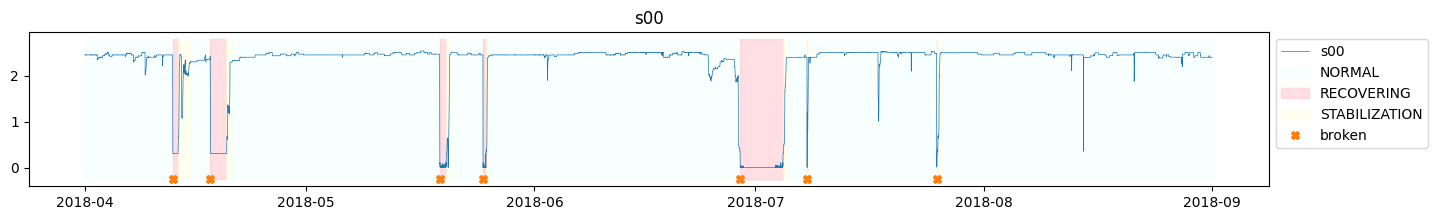

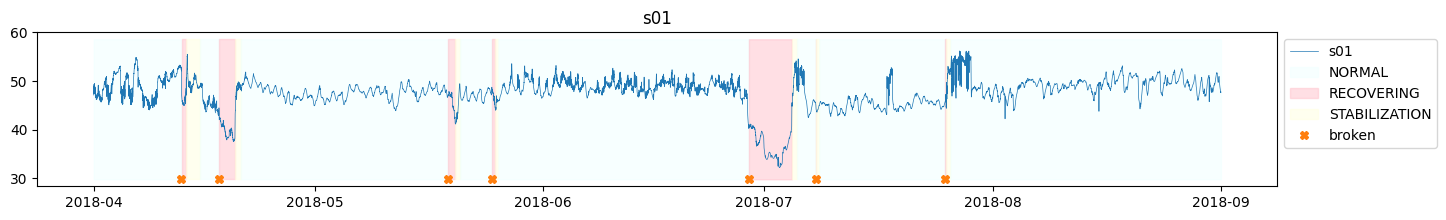

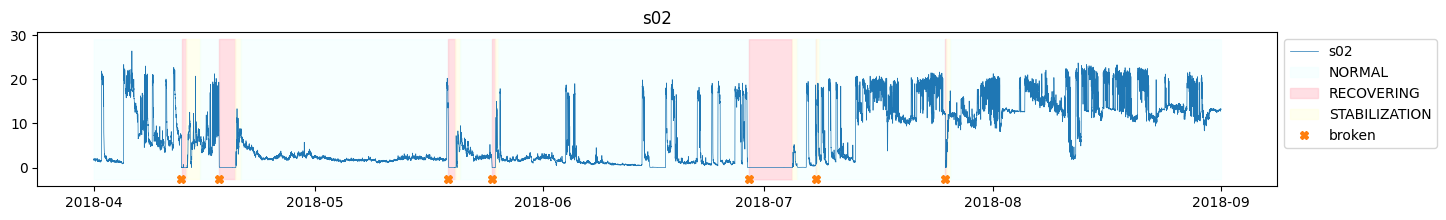

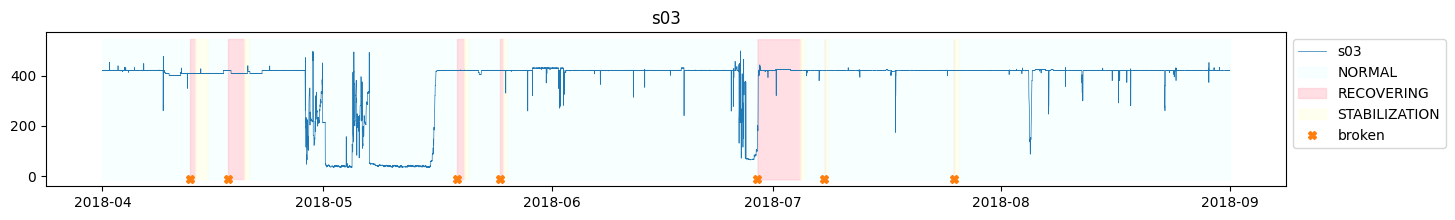

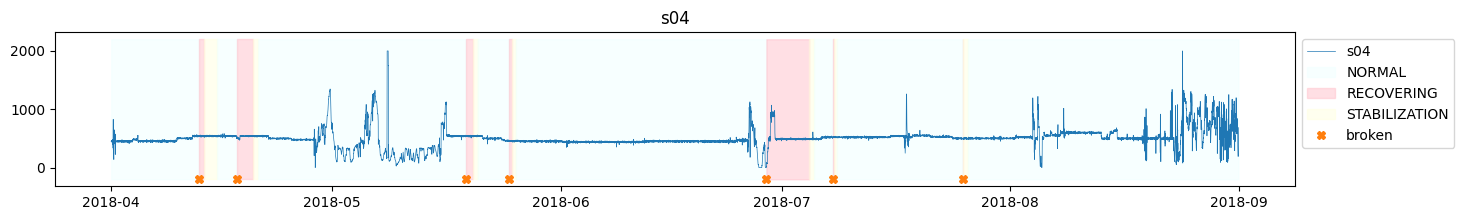

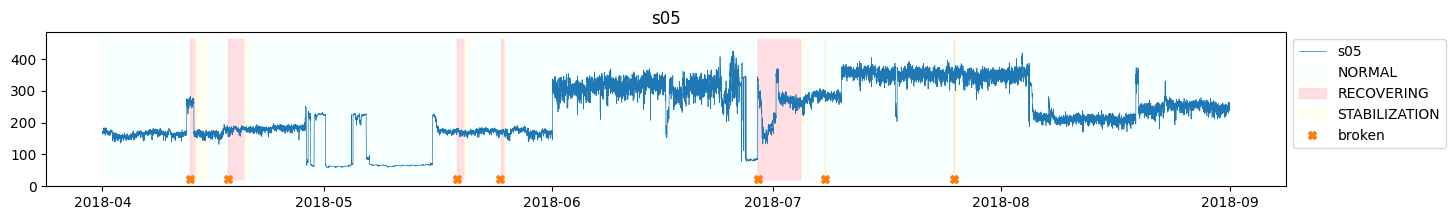

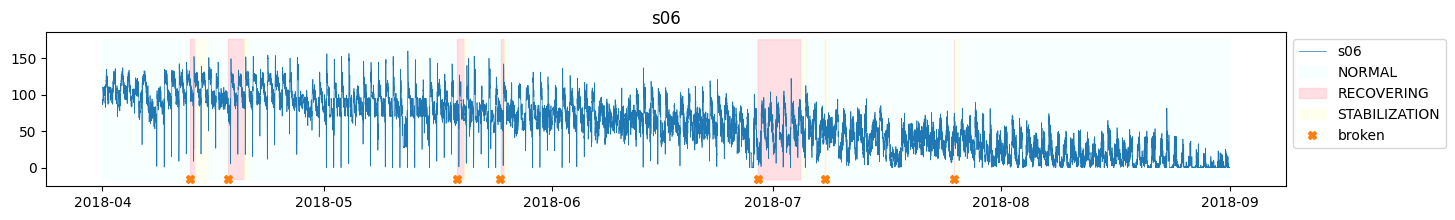

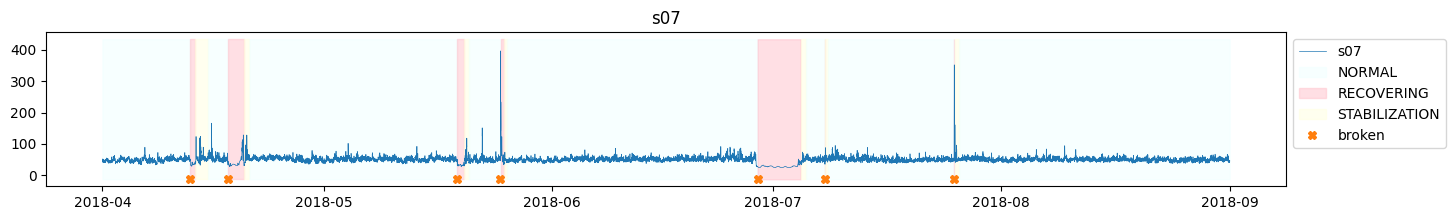

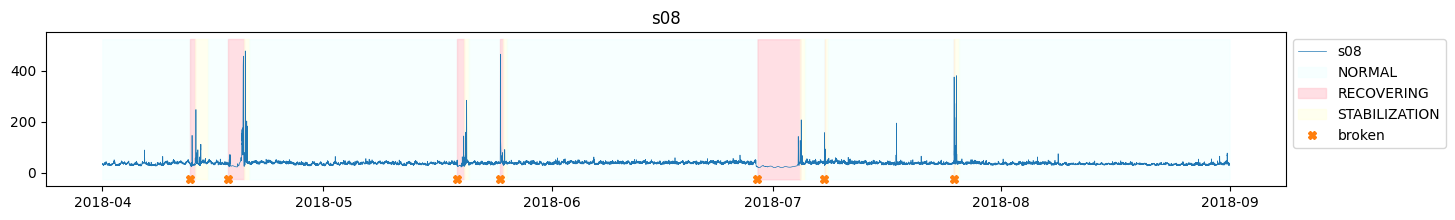

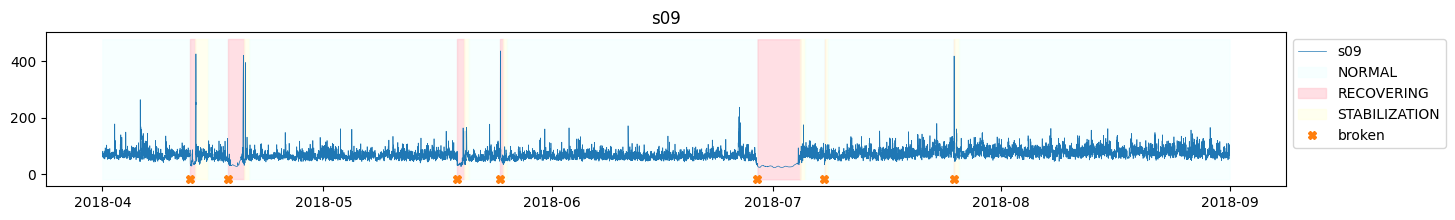

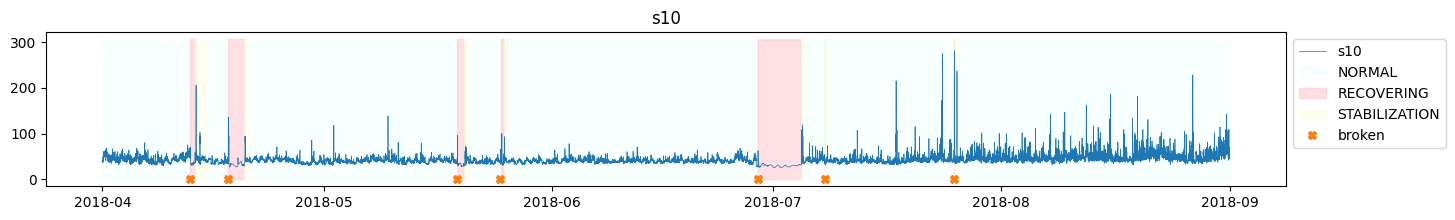

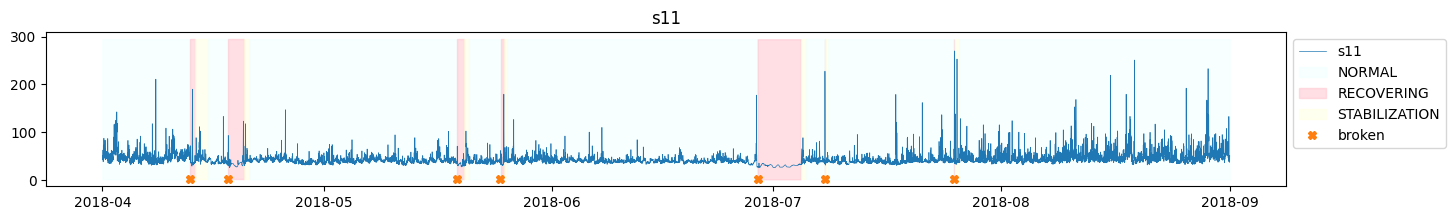

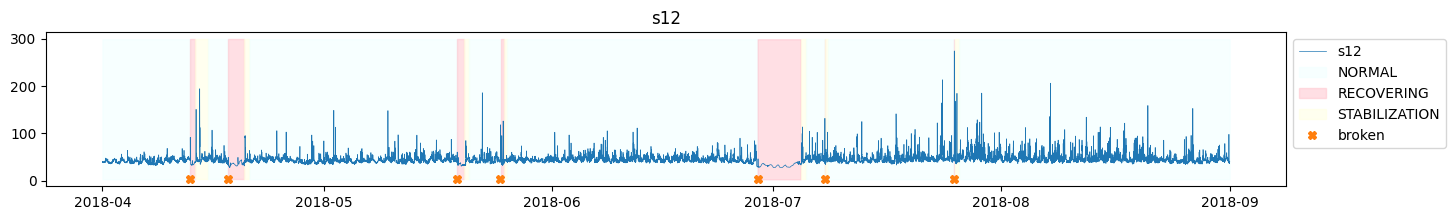

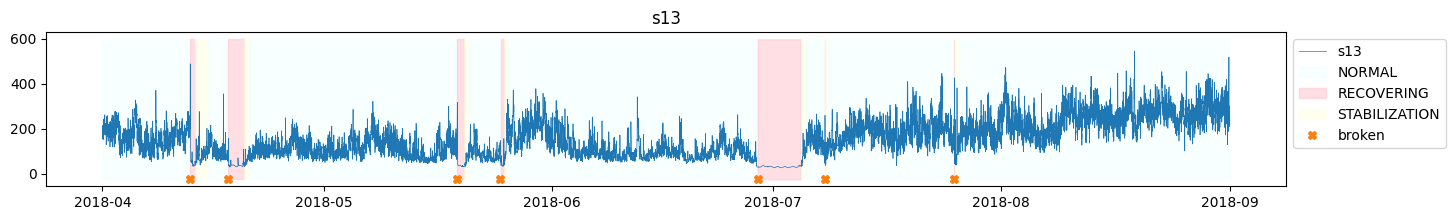

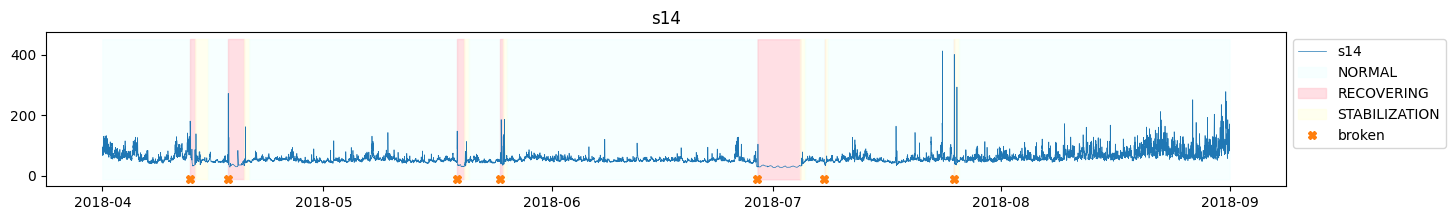

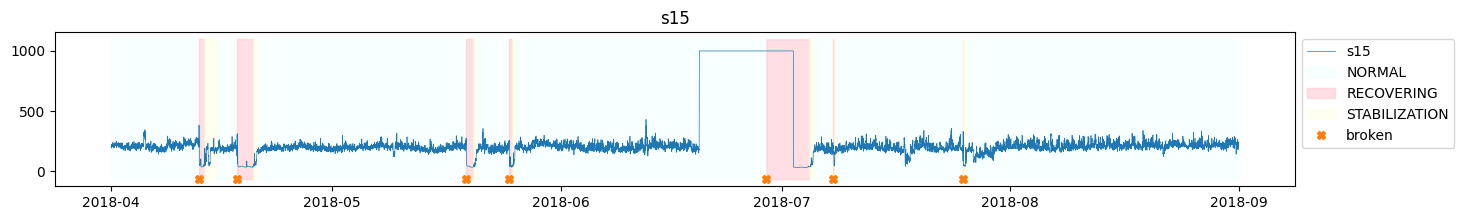

In [21]:
plot_anomaly_list(df)

In [22]:
broken_indices = df[df['machine_status'] == 'BROKEN'].index
indices = (
    pd.DatetimeIndex([df.index[0]])
    .append(broken_indices)
    .append(pd.DatetimeIndex([df.index[-1]]))
)

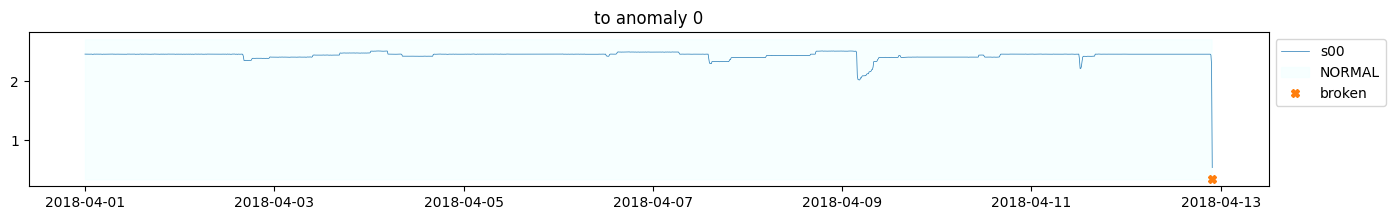

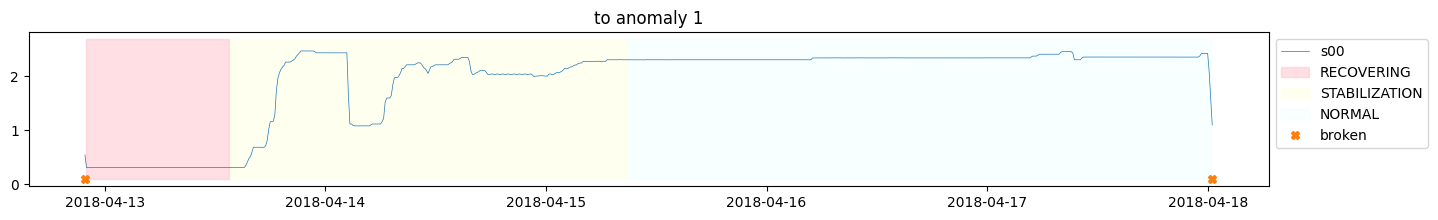

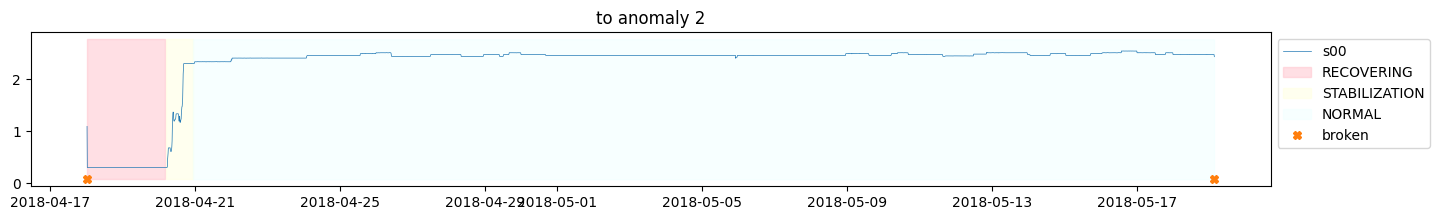

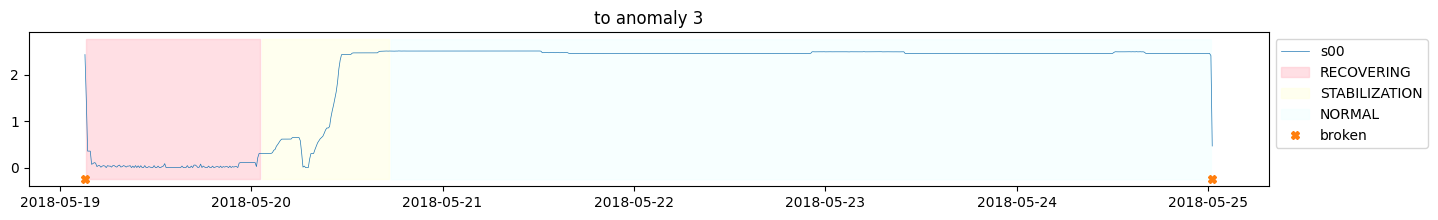

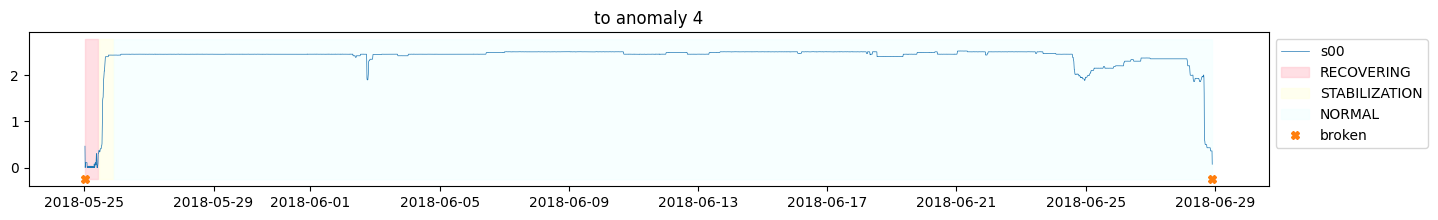

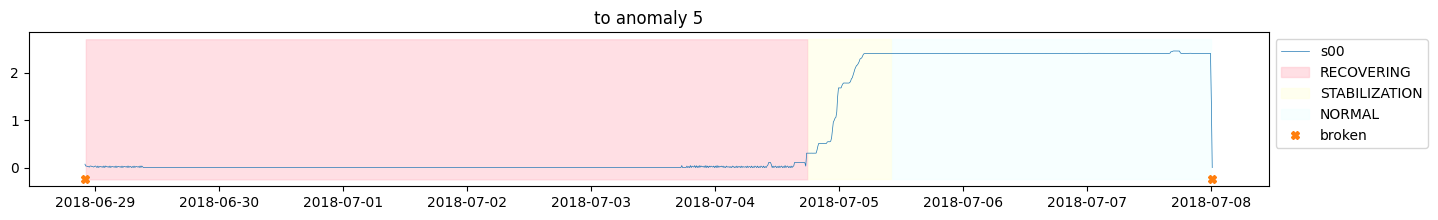

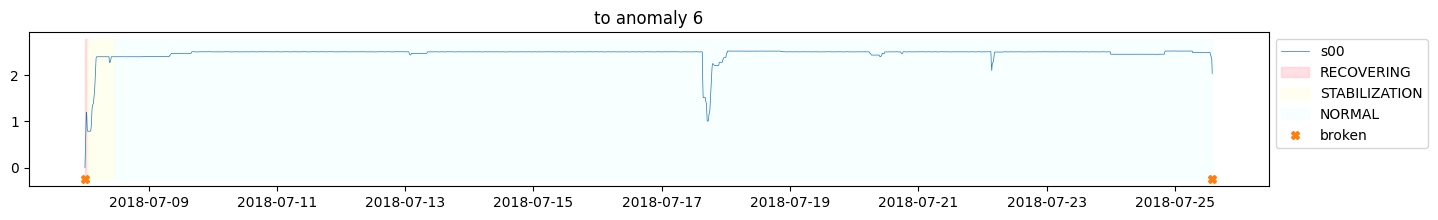

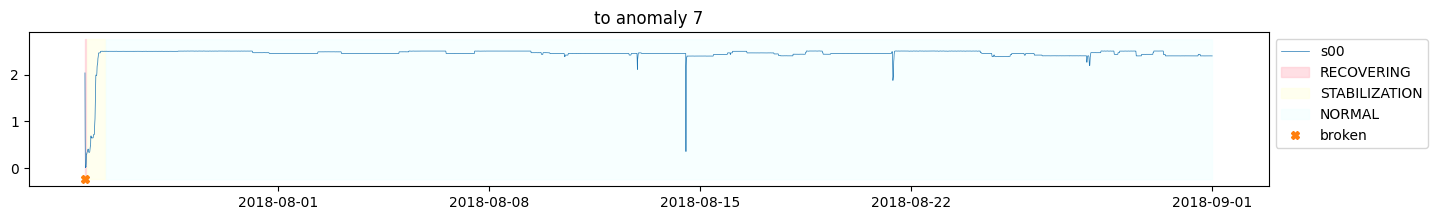

In [23]:
for i in range(len(indices) - 1):
    plot_anomaly_list(
        df.loc[indices[i]:indices[i+1]],
        s_list=["s00"],
        title=f"to anomaly {i}"
    )


# 特徴量エンジニアリング

## 特徴量生成

In [24]:
def generate_lag_features(df, periods):
    return df.shift(periods=periods).bfill().rename(
        columns={col: f"lag({col},{periods})" for col in df.columns}
    )

def generate_diff_features(df, periods):
    return df.diff(periods=periods).bfill().rename(
        columns={col: f"diff({col},{periods})" for col in df.columns}
    )

def generate_moving_median_features(df, window):
    return df.rolling(window=window).median().bfill().rename(
        columns={col: f"mm({col},{window})" for col in df.columns}
    )

def generate_moving_average_features(df, window):
    return df.rolling(window=window).mean().bfill().rename(
        columns={col: f"ma({col},{window})" for col in df.columns}
    )

def generate_moving_average_diff_features(df, window):
    return df.rolling(window=window).mean().bfill().rename(
        columns={col: f"ma({col},{window})" for col in df.columns}
    )


In [25]:
def generate_features(df, period, window, use_median, use_lag):
    new_df = df.copy()
    if period != None:
        if use_lag:
            func = generate_lag_features
        else:
            func = generate_diff_features

        new_df = new_df.pipe(func, periods=period)

    if window != None:
        if use_median:
            func = generate_moving_median_features
        else:
            func = generate_moving_average_features

        new_df = new_df.pipe(func, window=window)

    return new_df

In [26]:
tmp_df = df[["s00"]]
pd.concat([
    tmp_df,
    generate_lag_features(tmp_df[["s00"]], periods=1)
], axis=1).head()

,s00,"lag(s00,1)"
timestamp,,
2018-04-01 00:00:00,2.454966,2.454966
2018-04-01 00:10:00,2.455064,2.454966
2018-04-01 00:20:00,2.452899,2.455064
2018-04-01 00:30:00,2.456441,2.452899
2018-04-01 00:40:00,2.453391,2.456441


In [27]:
tmp_df = df.loc[:, ["s00"]]
pd.concat([
    tmp_df,
    generate_lag_features(tmp_df[["s00"]], periods=1)
], axis=1).head()

,s00,"lag(s00,1)"
timestamp,,
2018-04-01 00:00:00,2.454966,2.454966
2018-04-01 00:10:00,2.455064,2.454966
2018-04-01 00:20:00,2.452899,2.455064
2018-04-01 00:30:00,2.456441,2.452899
2018-04-01 00:40:00,2.453391,2.456441


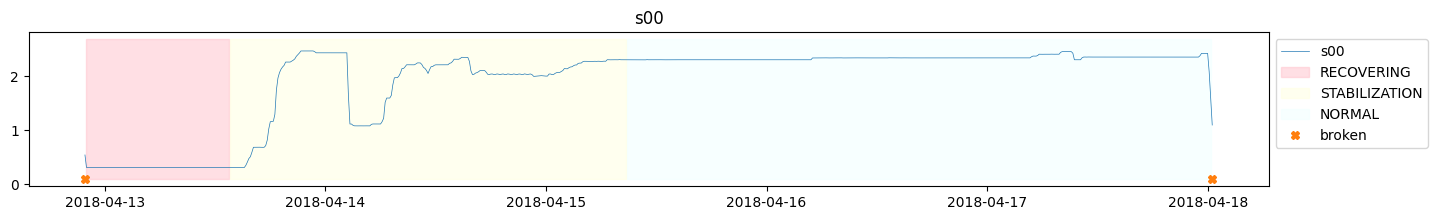

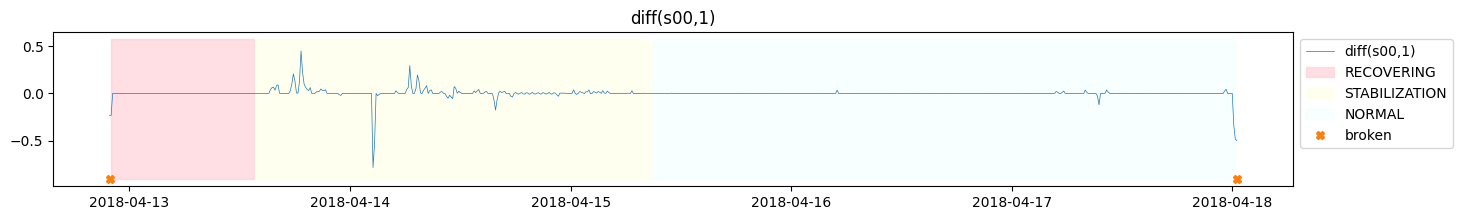

In [28]:
tmp_df = df.loc[broken_indices[0]:broken_indices[1], ["s00", "machine_status"]]
plot_anomaly_list(
    pd.concat([
        tmp_df,
        generate_diff_features(tmp_df[["s00"]], periods=1)
    ], axis=1),
)

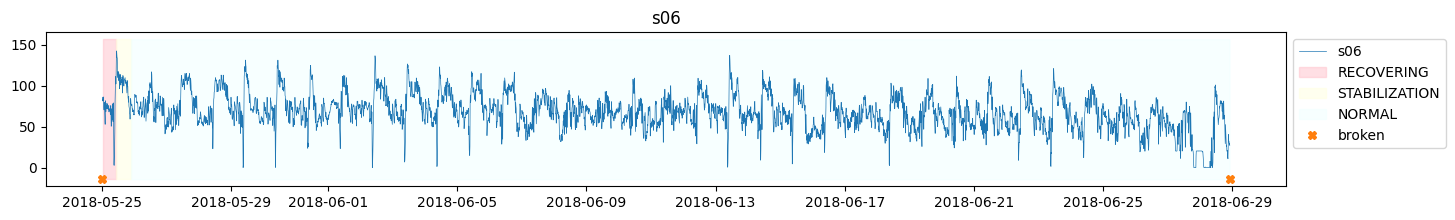

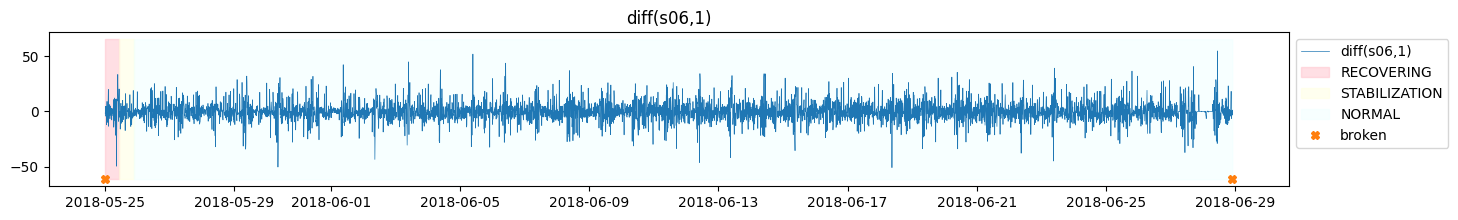

In [29]:
tmp_df = df.loc[broken_indices[3]:broken_indices[4], ["s06", "machine_status"]]
plot_anomaly_list(
    pd.concat([
        tmp_df,
        generate_diff_features(tmp_df[["s06"]], periods=1)
    ], axis=1),
)

In [30]:
pd.concat([
    tmp_df,
    generate_moving_average_features(tmp_df[["s06"]], window=20),
    generate_diff_features(tmp_df[["s06"]], periods=1),
    generate_diff_features(tmp_df[["s06"]], periods=1).pipe(
        generate_moving_average_features,
        window=20
    ),
    generate_moving_average_features(tmp_df[["s06"]], window=20).pipe(
        generate_diff_features,
        periods=20
    )
], axis=1).head()

,s06,machine_status,"ma(s06,20)","diff(s06,1)","ma(diff(s06,1),20)","diff(ma(s06,20),20)"
timestamp,,,,,,
2018-05-25 00:30:00,82.636407,BROKEN,73.652591,-1.449250,-0.592285,-0.206159
2018-05-25 00:40:00,81.187157,RECOVERING,73.652591,-1.449250,-0.592285,-0.206159
2018-05-25 00:50:00,85.893455,RECOVERING,73.652591,4.706298,-0.592285,-0.206159
2018-05-25 01:00:00,81.652004,RECOVERING,73.652591,-4.241451,-0.592285,-0.206159
2018-05-25 01:10:00,81.391446,RECOVERING,73.652591,-0.260558,-0.592285,-0.206159


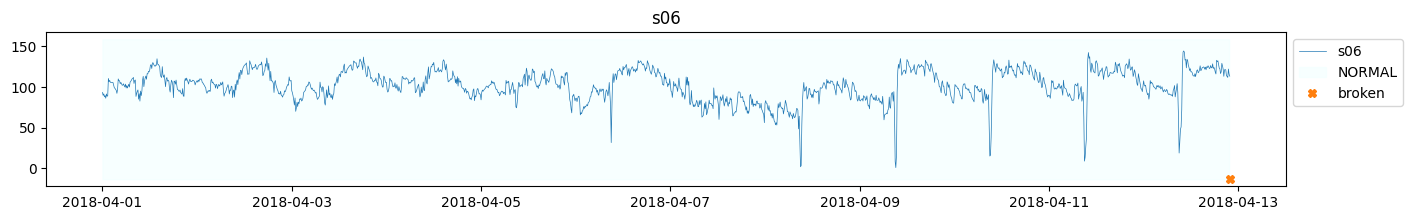

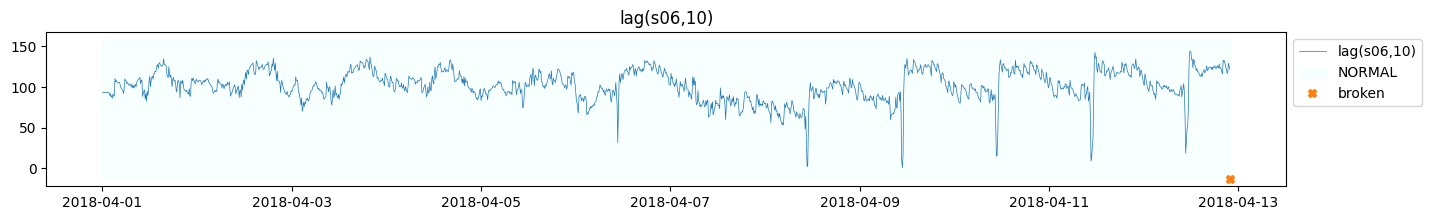

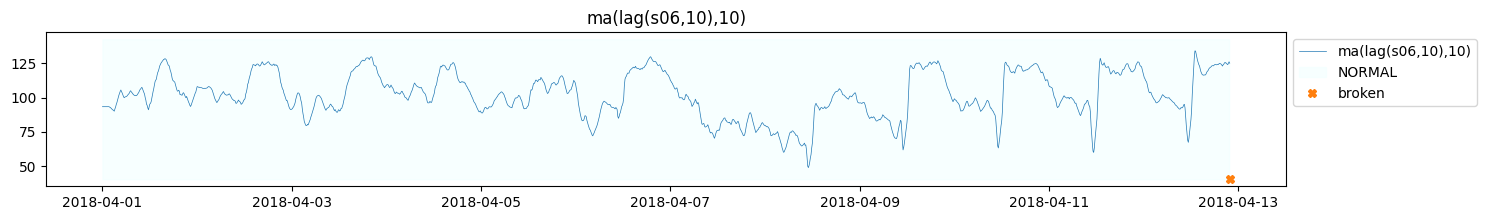

In [31]:
tmp_df = df.loc[:broken_indices[0], ["s06", "machine_status"]]
plot_anomaly_list(
    pd.concat([
        tmp_df,  # 元のセンサーデータ
        generate_lag_features(tmp_df[["s06"]], periods=10),  # ラグ特徴量
        generate_lag_features(tmp_df[["s06"]], periods=10).pipe(
            generate_moving_average_features,
            window=10,
        ),  # 移動平均ラグ特徴量
    ], axis=1),
)

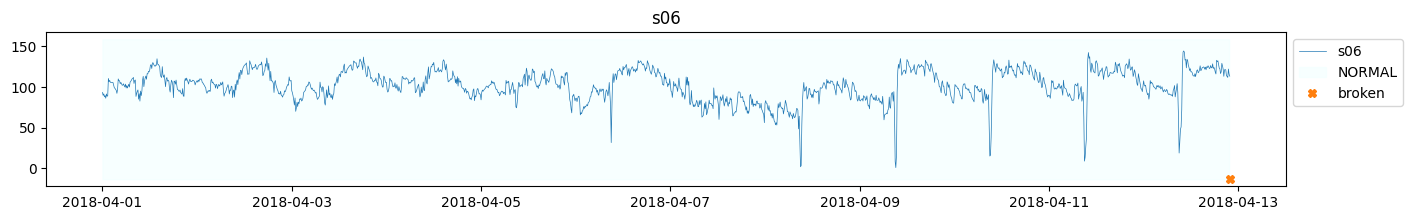

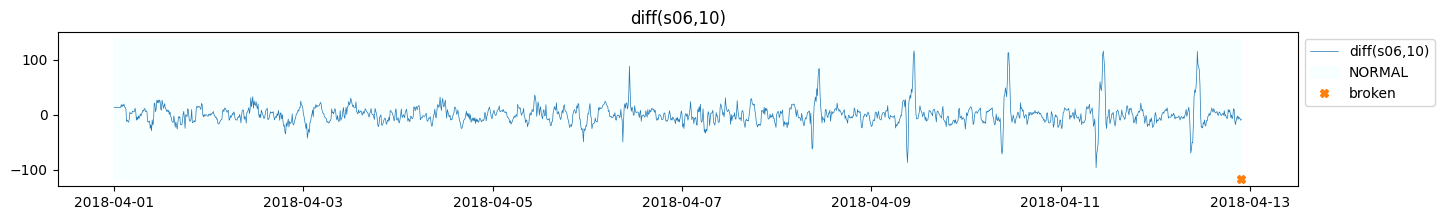

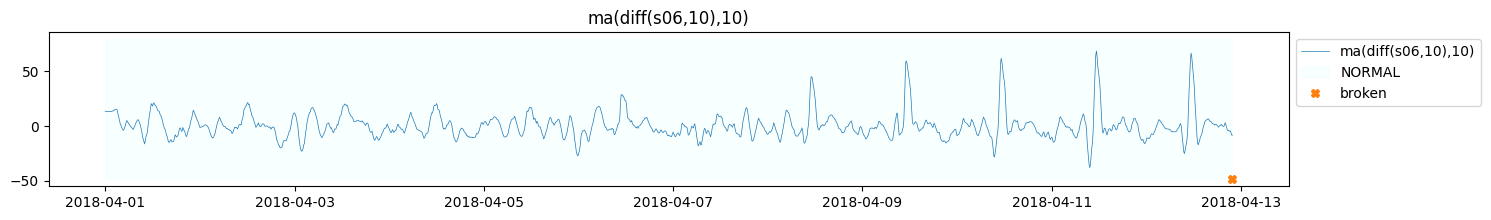

In [32]:
tmp_df = df.loc[:broken_indices[0], ["s06", "machine_status"]]
plot_anomaly_list(
    pd.concat([
        tmp_df,  # 元のセンサーデータ
        generate_diff_features(tmp_df[["s06"]], periods=10),  # 差分特徴量
        generate_diff_features(tmp_df[["s06"]], periods=10).pipe(
            generate_moving_average_features,
            window=10,
        ),  # 移動平均差分特徴量
    ], axis=1),
)

## 特徴量選択

In [33]:
def select_features(df: pd.DataFrame):
    periods = [None, 1, 3, 6, 12, 18]
    use_lags = [True, False]
    windows = [None, 1, 3, 6, 12, 18]
    use_medians = [True]

    result_df = df.copy()
    selected_feature_params = []
    for original_col in df.filter(regex="^s\d\d").columns:
        print(original_col)
        new_dfs = []
        for period, window, use_lag in product(
            periods, windows, use_lags,
        ):
            if period is None and window is None:
                continue

            if period is None and use_lags:
                continue

            sensors_df = df[[original_col]]
            new_df = generate_features(
                sensors_df, period, window,
                use_median=True, use_lag=use_lag
            )
            new_dfs.append(new_df)

        features_df = pd.concat(new_dfs, axis=1)
        print(features_df.shape)
        features_df = drop_highly_correlated_columns(features_df)
        print(features_df.shape)

        result_df = pd.concat(
            [result_df, features_df],
            axis=1
        )
        print()

    print(f"selected: {result_df.columns}")
    return result_df, selected_feature_params

In [34]:
normal_df = df[df["machine_status"] == "NORMAL"].drop(columns=["machine_status"])

In [35]:
features_df, selected_feature_params = select_features(normal_df)

s00
(19797, 60)
(19797, 9)

s01
(19797, 60)
(19797, 7)

s02
(19797, 60)
(19797, 11)

s03
(19797, 60)
(19797, 8)

s04
(19797, 60)
(19797, 8)

s05
(19797, 60)
(19797, 14)

s06
(19797, 60)
(19797, 9)

s07
(19797, 60)
(19797, 15)

s08
(19797, 60)
(19797, 17)

s09
(19797, 60)
(19797, 16)

s10
(19797, 60)
(19797, 15)

s11
(19797, 60)
(19797, 14)

s12
(19797, 60)
(19797, 15)

s13
(19797, 60)
(19797, 14)

s14
(19797, 60)
(19797, 14)

s15
(19797, 60)
(19797, 13)

selected: Index(['s00', 's01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       ...
       'mm(diff(s15,1),6)', 'mm(diff(s15,1),12)', 'mm(diff(s15,1),18)',
       'mm(diff(s15,3),3)', 'mm(diff(s15,3),6)', 'mm(diff(s15,3),12)',
       'mm(diff(s15,3),18)', 'mm(diff(s15,6),12)', 'mm(diff(s15,6),18)',
       'diff(s15,12)'],
      dtype='object', length=215)


In [36]:
features_df.shape

(19797, 215)

# 機械学習用メソッド

In [37]:
def create_preprocessor(numeric_feature_names: list[str]):
    numeric_transformer = Pipeline(steps=[
        # ('feature_transformer', MultiVariateTSFreshFeatureExtractor()),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_names),
        ]
    )
    return preprocessor

In [38]:
def create_pipeline(anomaly_detector, numeric_feature_names: list[str]):
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor(
            numeric_feature_names=numeric_feature_names
        )),
        ('anomaly_detector', anomaly_detector),
    ])
    return pipeline

In [39]:
def predict(df, predicted_func, score_func):
    predictions_df = pd.DataFrame(
        predicted_func(df),
        index=df.index,
        columns=["predicted"]
    )
    scores_df = pd.DataFrame(
        score_func(df),
        index=df.index,
        columns=["score"]
    )
    result_df = (
        pd.DataFrame(
            index=pd.date_range(start=df.index.min(), end=df.index.max(), freq="10T")
        )
        .join(predictions_df)
        .join(scores_df)
    )
    return result_df

In [40]:
def _regard_sequential_anomaries_as_one_anomaly(predicted, interval = 0):
    predicted.name = "predicted"
    reset_predicted = predicted.reset_index()
    new_predicted = pd.Series(
        name="predicted", index=predicted.index, dtype="float64"
    )
    for i, row in reset_predicted.iterrows():
      if (
          row["predicted"] == -1 and
          -1 in reset_predicted.iloc[
              max(0, i - interval - 1):i
          ]["predicted"].tolist()
      ):
        new_predicted.iloc[i] = 1
      else:
        new_predicted.iloc[i] = row["predicted"]

    return new_predicted

def _rescaling(sr, min_v, max_v):
    sr = (sr - sr.min()) / (sr.max() - sr.min())
    sr = sr * (max_v - min_v) + min_v
    return sr

def plot_predicted_result(
    df: pd.DataFrame, original_df: pd.DataFrame,
    extra_df: Optional[pd.DataFrame] = None,
    sensor_id: Optional[str] = None,
    threshold: Optional[float] = None,
    title: Optional[str] = None,
    score_label: Optional[str] = None,
    extra_score_label: Optional[str] = None,
):
    df = (
        df.join(original_df["machine_status"])
    )
    if sensor_id:
        df = df.join(original_df[sensor_id])

    if threshold is None:
        threshold = df["score"].quantile(
            1 - 10/(24*60/10)  # 1日に10回程度
        )
    print(f"threshold: {threshold}")

    predicted = df["score"].apply(
        lambda x: -1 if x < threshold else 1
    ).pipe(
        _regard_sequential_anomaries_as_one_anomaly,
        interval=6,  # 1時間以内に再度起こった検知は同一検知と見なす
    )
    machine_status = df["machine_status"]
    score = df["score"]

    min_v = score.min()
    max_v = score.max()
    anomaly_y = min_v - (max_v - min_v) * 0.1
    normal_y = max_v + (max_v - min_v) * 0.1

    plt.figure(figsize=(16, 2))

    regions = detect_status_regions(df)

    # machine_status のプロット
    colors = {
        "NORMAL": "azure",
        "STABILIZATION": "lightyellow",
        "RECOVERING": "mistyrose",
        "MISSING": "gray",
    }
    for region in regions:
        if region["status"] == "BROKEN":
            continue

        plt.fill_between(
            df.iloc[region["begin"]:region["end"]].index,
            anomaly_y,
            normal_y,
            color=colors[region["status"]],
            label=region["status"],
        )

    # センサーデータのプロット
    if sensor_id:
        sensor = df[sensor_id]
        sensor = _rescaling(df[sensor_id], score.min(), score.max())
        plt.plot(sensor.ffill(),
                 linewidth=0.5, label=sensor_id)

    # 予測スコアのプロット
    plt.plot(score.ffill(),
             linewidth=0.5, label=score_label or "prediction score")

    if extra_df is not None:
        # 予測スコア(追加分)のプロット
        extra_score = _rescaling(extra_df["score"], score.min(), score.max())
        plt.plot(
            extra_score.ffill(),
            linestyle="--", linewidth=1.5,
            label=extra_score_label or "prediction score (extra)"
        )
    else:
        # 異常と予測した点のプロット
        predicted_as_anomaly = mask_and_other_is_nan(
            predicted,
            predicted == ANOMALY_LABEL,
            anomaly_y
        )
        plt.plot(
            predicted_as_anomaly, linestyle="none", marker="x",
            label="predicted as anomaly"
        )

        # 正常と予測した点のプロット
        predicted_as_normal = mask_and_other_is_nan(
            predicted,
            predicted == NORMAL_LABEL,
            normal_y,
        )
        plt.plot(
            predicted_as_normal, linestyle="none", marker=".",
            markersize=1, label="predicted as normal"
        )

        # BROKEN ラベルが付与された点のプロット
        actually_broken = mask_and_other_is_nan(
            machine_status,
            machine_status == "BROKEN",
            anomaly_y,
        )
        plt.plot(
            actually_broken, linestyle="none", marker="X",
            label="broken"
        )

        n_predicted_as_anomaly = len(predicted_as_anomaly.dropna())
        days = (df.index.max() - df.index.min()).total_seconds() / (60 * 60 * 24)
        print(
            f"Predicted {n_predicted_as_anomaly} anomalies "
            f"({n_predicted_as_anomaly / days:.1f} anomalies / day)"
        )
        print(
            "Last 5 points predicted as anomaly is :"
        )
        for timedelta in (
            predicted.index.max() -
            predicted_as_anomaly.dropna().index.sort_values(ascending=False)[:5]
        ):
            print(f"{timedelta} before")

    plt.title(title or "Predicted Result")
    plt.legend()
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.show()


In [41]:
def plot_predicted_results(
    result_df, original_df, sensor_id: Optional[str] = None,
    extra_result_df: Optional[pd.DataFrame] = None,
    threshold: Optional[float] = None,
    score_label: Optional[str] = None,
    extra_score_label: Optional[str] = None,
):
    broken_indices = df[df['machine_status'] == 'BROKEN'].index
    indices = (
        pd.DatetimeIndex([df.index[0]])
        .append(broken_indices)
        .append(pd.DatetimeIndex([df.index[-1]]))
    )
    for i in range(len(indices) - 1):
        sub_df = result_df.loc[indices[i]:indices[i+1]]
        if extra_result_df is not None:
            extra_sub_df = extra_result_df.loc[indices[i]:indices[i+1]]
        else:
            extra_sub_df = None

        if i == len(indices) - 1:
            title = "Predicted result to end"
        else:
            title = f"Predicted result to anomaly {i}"

        if len(sub_df.dropna()) > 0:
            plot_predicted_result(
                sub_df,
                original_df=original_df,
                sensor_id=sensor_id,
                extra_df=extra_sub_df,
                threshold=threshold,
                title=f"Predicted result for anomaly {i}",
                score_label=score_label,
                extra_score_label=extra_score_label,
            )

# Isolation Forest

In [42]:
pipeline_isolationforest = create_pipeline(
    anomaly_detector=IsolationForest(
        n_estimators=100,
        random_state=1234,
    ),
    numeric_feature_names=features_df.columns.tolist()
)

In [43]:
pipeline_isolationforest.fit(features_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['s00', 's01', 's02', 's03',
                                                   's04', 's05', 's06', 's07',
                                                   's08', 's09', 's10', 's11',
                                                   's12', 's13', 's14', 's15',
                                                   'lag(s00,1)', 'diff(s00,1)',
                                                   'mm(diff(s00,1),3)',
                                                   'mm(diff(s00,1),6)',
                                                   'mm(diff(s00,1),12)',
                                                   'diff(s00,3)',
                                                   'mm(diff(s00,3),3)',
                                                   'mm(diff(s00,3),6)',
                                                   'mm(diff(s00,6),12)',
                                                   'lag(s01,1)', 'diff(s01,1)',
                                                   'mm(diff(s01,1),3)',
                                                   'mm(diff(s01,1),6)',
                                                   'mm(diff(s01,1),12)', ...])])),
                ('anomaly_detector', IsolationForest(random_state=1234))])

In [44]:
predicted_isolationforest_df = predict(
    features_df,
    predicted_func=pipeline_isolationforest.predict,
    score_func=pipeline_isolationforest.decision_function,
)

In [45]:
predicted_isolationforest_df.head()

,predicted,score
2018-04-01 00:00:00,1.0,0.119840
2018-04-01 00:10:00,1.0,0.120751
2018-04-01 00:20:00,1.0,0.116978
2018-04-01 00:30:00,1.0,0.126795
2018-04-01 00:40:00,1.0,0.127305


In [46]:
broken_indices

DatetimeIndex(['2018-04-12 21:50:00', '2018-04-18 00:30:00',
               '2018-05-19 03:10:00', '2018-05-25 00:30:00',
               '2018-06-28 22:00:00', '2018-07-08 00:10:00',
               '2018-07-25 14:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

threshold: 0.08
Predicted 14 anomalies (1.2 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 08:10:00 before
2 days 12:20:00 before
3 days 17:10:00 before
4 days 09:20:00 before
4 days 11:10:00 before


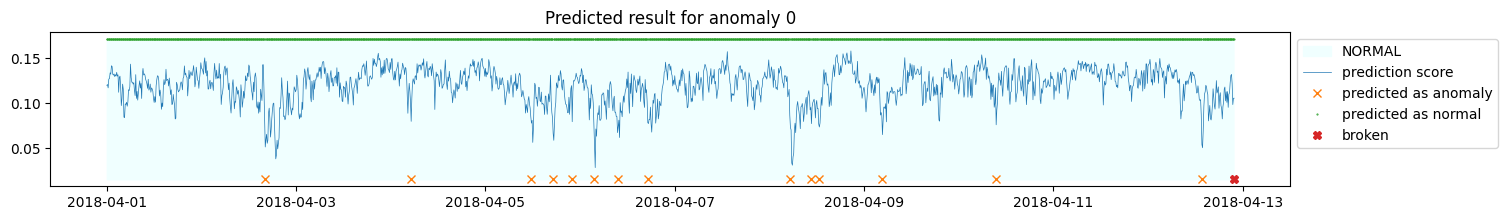

threshold: 0.08
Predicted 3 anomalies (0.6 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 14:50:00 before
2 days 05:20:00 before
2 days 15:40:00 before


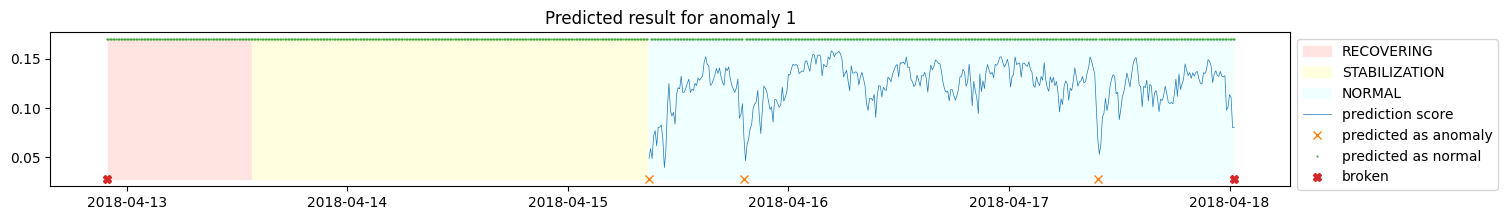

threshold: 0.08
Predicted 16 anomalies (0.5 anomalies / day)
Last 5 points predicted as anomaly is :
2 days 15:40:00 before
5 days 11:00:00 before
5 days 14:40:00 before
5 days 17:30:00 before
7 days 23:40:00 before


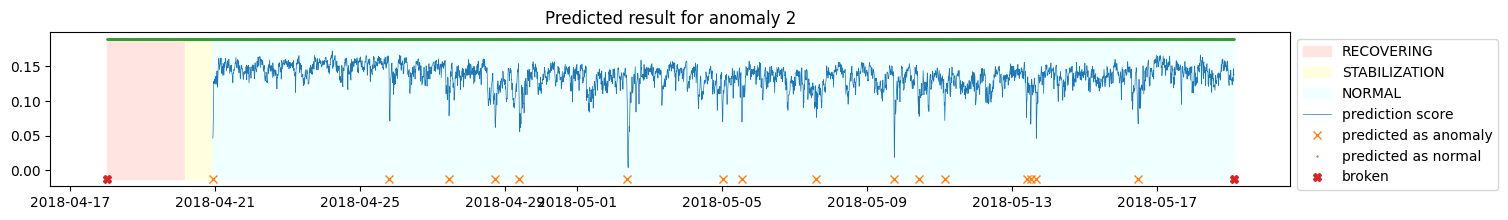

threshold: 0.08
Predicted 4 anomalies (0.7 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:20:00 before
2 days 11:20:00 before
3 days 08:20:00 before
3 days 13:30:00 before


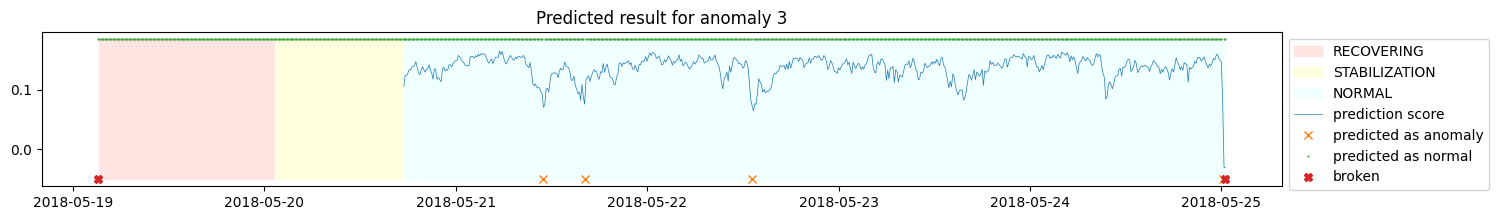

threshold: 0.08
Predicted 31 anomalies (0.9 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 10:50:00 before
0 days 14:00:00 before
0 days 17:30:00 before
0 days 21:00:00 before
1 days 00:50:00 before


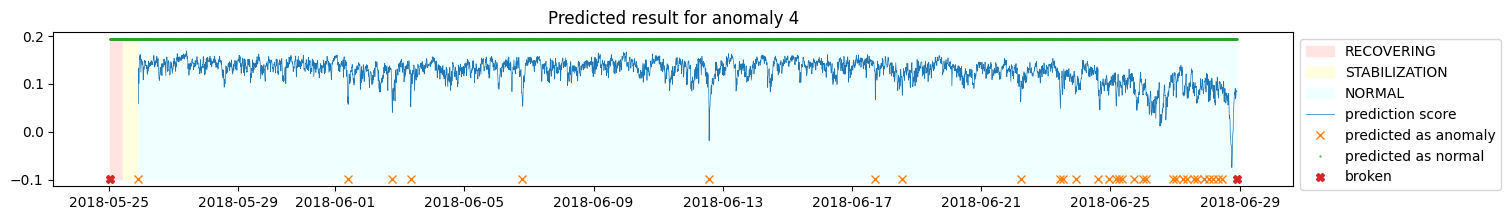

threshold: 0.08
Predicted 3 anomalies (0.3 anomalies / day)
Last 5 points predicted as anomaly is :
1 days 04:50:00 before
1 days 14:30:00 before
2 days 14:00:00 before


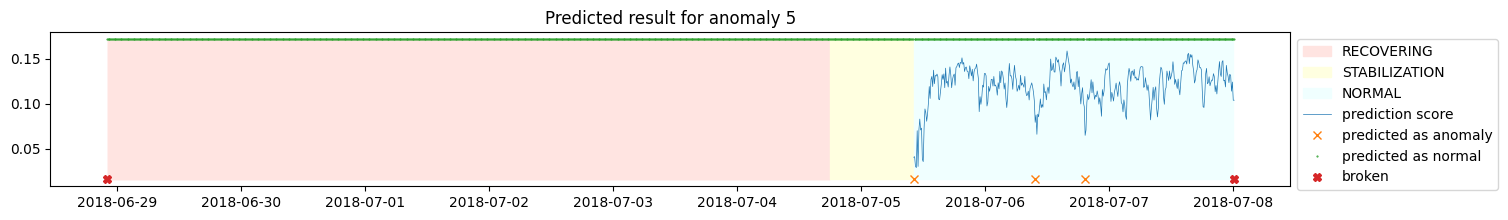

threshold: 0.08
Predicted 23 anomalies (1.3 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 09:30:00 before
0 days 13:40:00 before
1 days 17:20:00 before
1 days 20:30:00 before
2 days 06:30:00 before


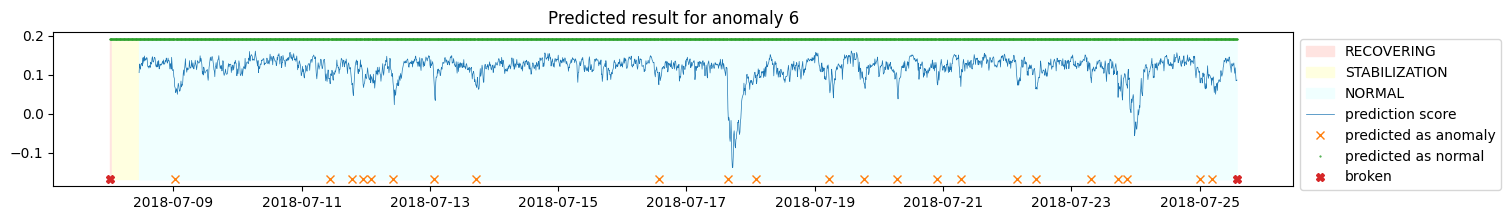

threshold: 0.08
Predicted 113 anomalies (3.0 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 17:40:00 before
1 days 04:00:00 before
1 days 09:10:00 before
1 days 16:30:00 before
1 days 18:20:00 before


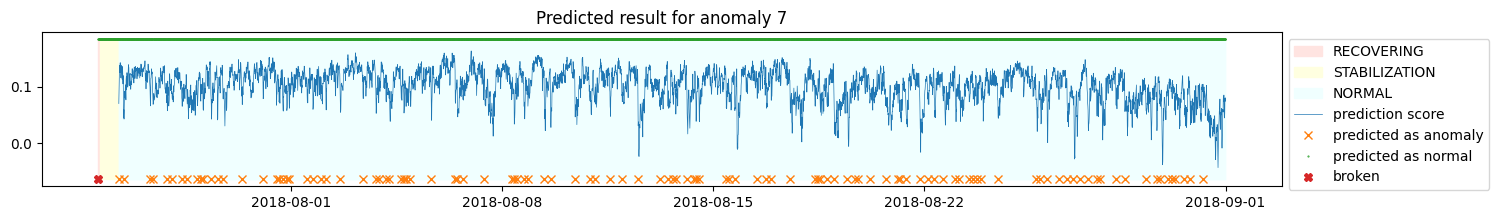

In [47]:
plot_predicted_results(
    predicted_isolationforest_df,
    original_df=df,
    threshold=0.08,
)

# Local Outlier Factor (LOF)

In [48]:
pipeline_lof = create_pipeline(
    anomaly_detector=LocalOutlierFactor(
        n_neighbors=20,
        # contamination=0.01,
        # contamination=10/(6*24),  # 1日に10回程度
    ),
    numeric_feature_names=features_df.columns.tolist()
)

In [49]:
predicted_lof_df = predict(
    features_df,
    predicted_func=pipeline_lof.fit_predict,
    score_func=lambda x: pipeline_lof[1].negative_outlier_factor_,
)

threshold: -1.5
Predicted 6 anomalies (6.0 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:50:00 before
0 days 09:40:00 before
0 days 12:30:00 before
0 days 15:00:00 before
0 days 18:50:00 before


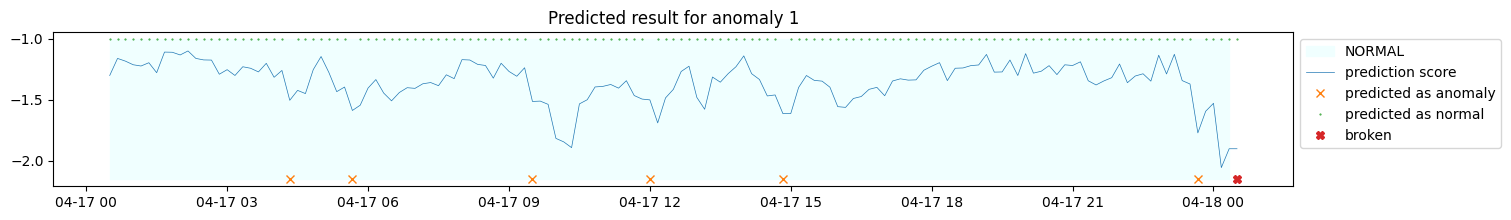

In [50]:
plot_predicted_results(
    predicted_lof_df[broken_indices[1] - pd.Timedelta(days=1):broken_indices[1]],
    original_df=df,
    threshold=-1.5,
)

threshold: -1.5
Predicted 29 anomalies (2.4 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:10:00 before
0 days 17:40:00 before
1 days 09:30:00 before
2 days 04:30:00 before
2 days 12:20:00 before


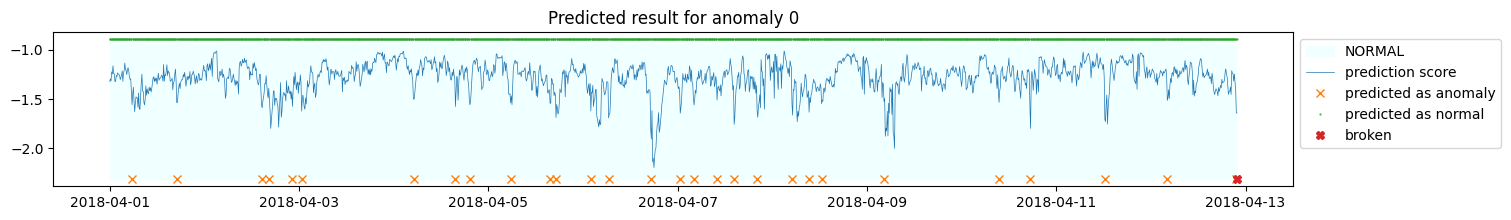

threshold: -1.5
Predicted 11 anomalies (2.2 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:50:00 before
0 days 09:40:00 before
0 days 12:30:00 before
0 days 15:00:00 before
0 days 18:50:00 before


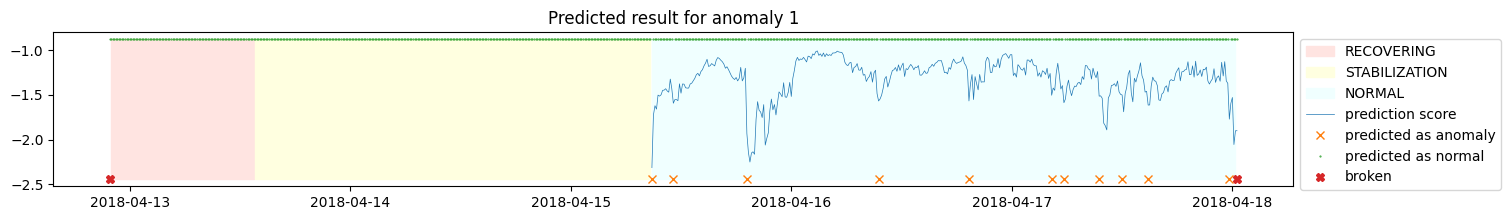

threshold: -1.5
Predicted 39 anomalies (1.3 anomalies / day)
Last 5 points predicted as anomaly is :
1 days 03:50:00 before
2 days 15:00:00 before
2 days 19:10:00 before
3 days 08:40:00 before
4 days 20:40:00 before


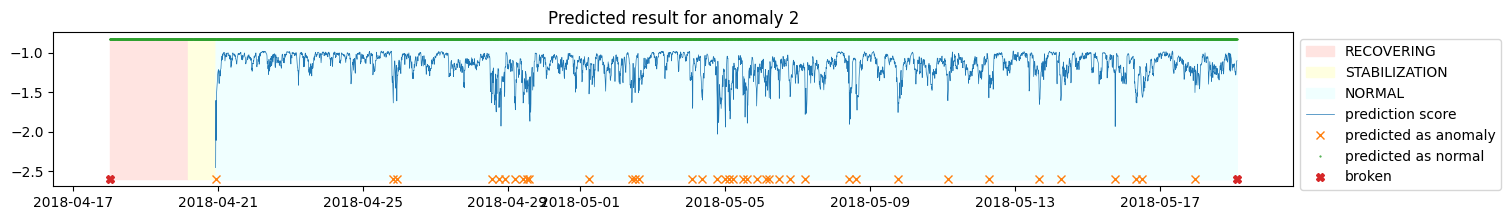

threshold: -1.5
Predicted 4 anomalies (0.7 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:20:00 before
1 days 09:50:00 before
1 days 18:10:00 before
2 days 11:40:00 before


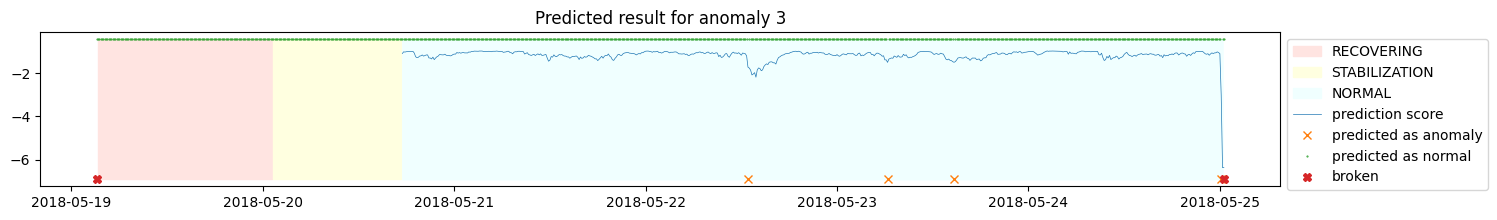

threshold: -1.5
Predicted 47 anomalies (1.3 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 06:30:00 before
1 days 04:50:00 before
1 days 14:50:00 before
1 days 16:10:00 before
1 days 21:20:00 before


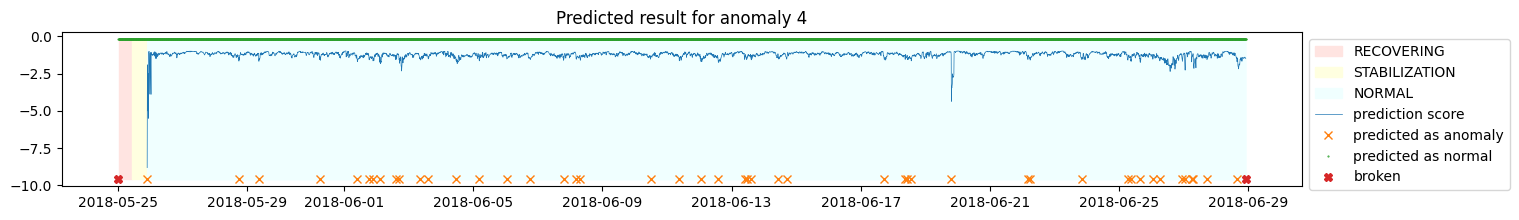

threshold: -1.5
Predicted 9 anomalies (1.0 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:10:00 before
0 days 13:20:00 before
0 days 16:30:00 before
1 days 04:50:00 before
1 days 15:50:00 before


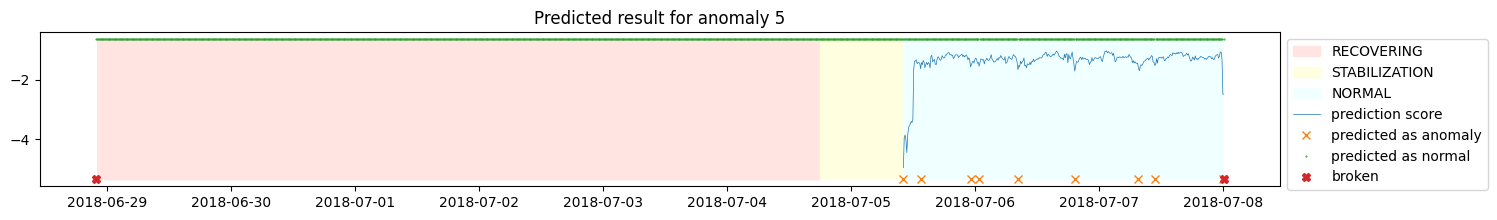

threshold: -1.5
Predicted 28 anomalies (1.6 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 00:10:00 before
0 days 07:30:00 before
0 days 10:20:00 before
0 days 12:30:00 before
1 days 16:10:00 before


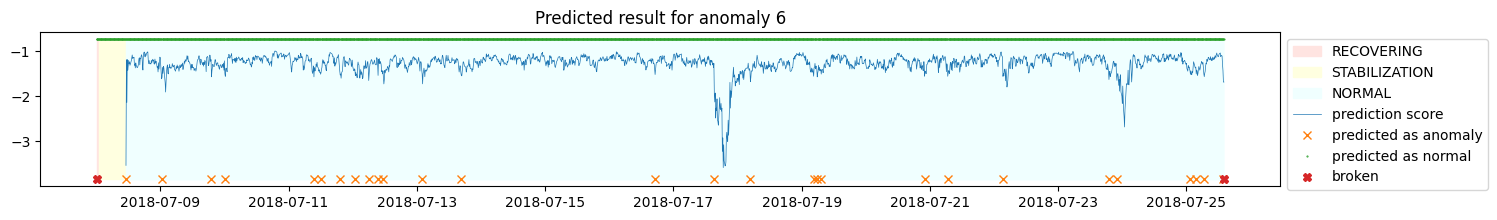

threshold: -1.5
Predicted 105 anomalies (2.8 anomalies / day)
Last 5 points predicted as anomaly is :
0 days 14:00:00 before
0 days 15:50:00 before
0 days 20:30:00 before
0 days 22:10:00 before
1 days 02:40:00 before


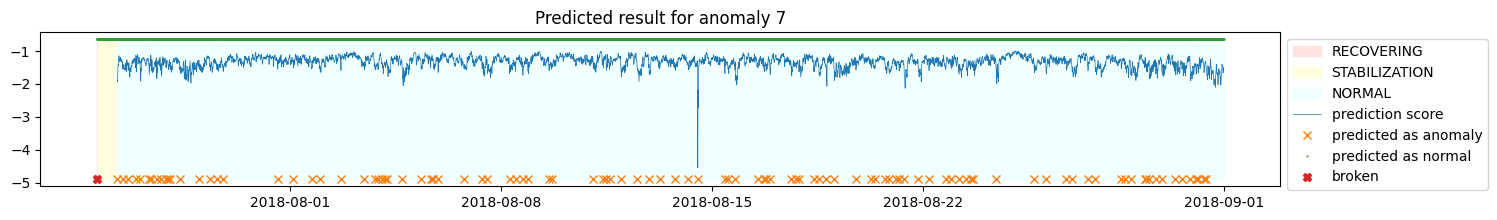

In [51]:
plot_predicted_results(predicted_lof_df, original_df=df, threshold=-1.5)

# Isolation Forest と LOF の比較

threshold: -1.159765037559263


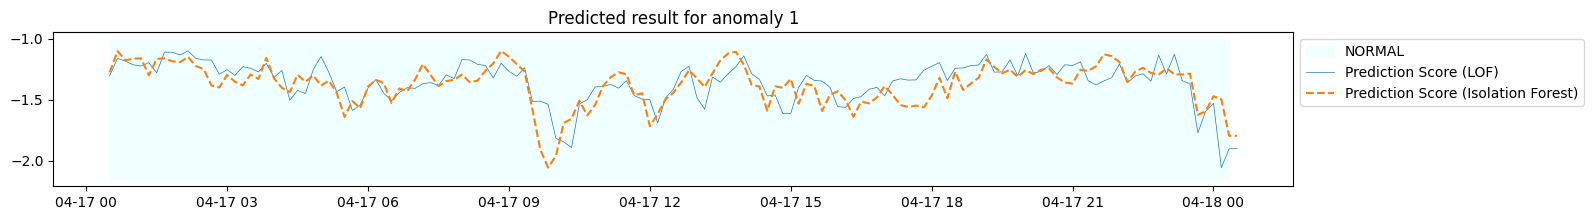

In [52]:
end = broken_indices[1]
begin = end - pd.Timedelta(days=1)

plot_predicted_results(
    predicted_lof_df[begin:end],
    extra_result_df=predicted_isolationforest_df[begin:end],
    original_df=df,
    score_label="Prediction Score (LOF)",
    extra_score_label="Prediction Score (Isolation Forest)"
)

threshold: -1.5


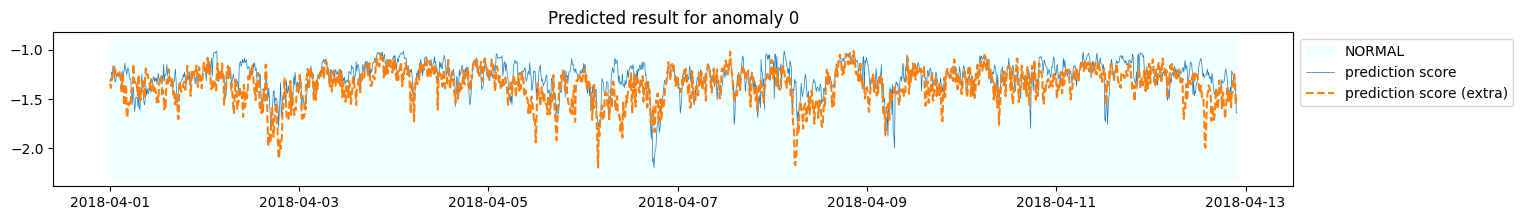

threshold: -1.5


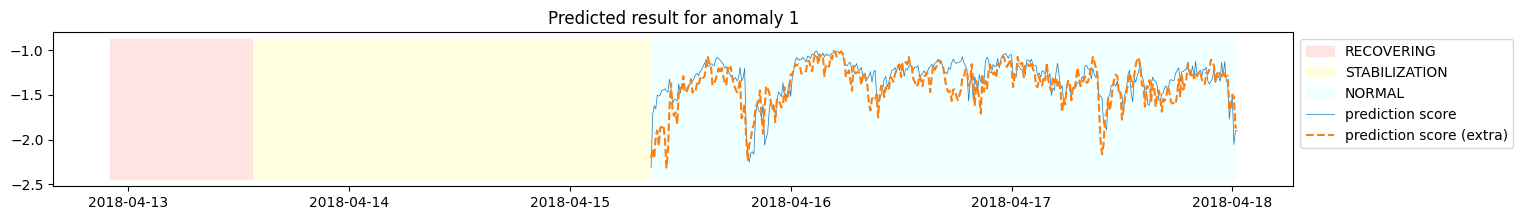

threshold: -1.5


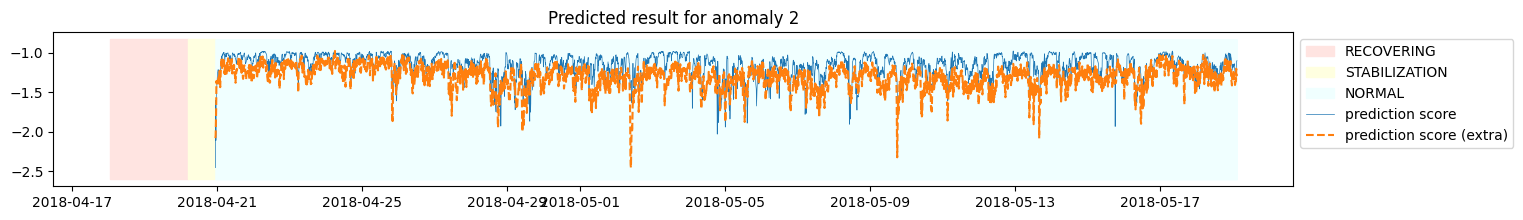

threshold: -1.5


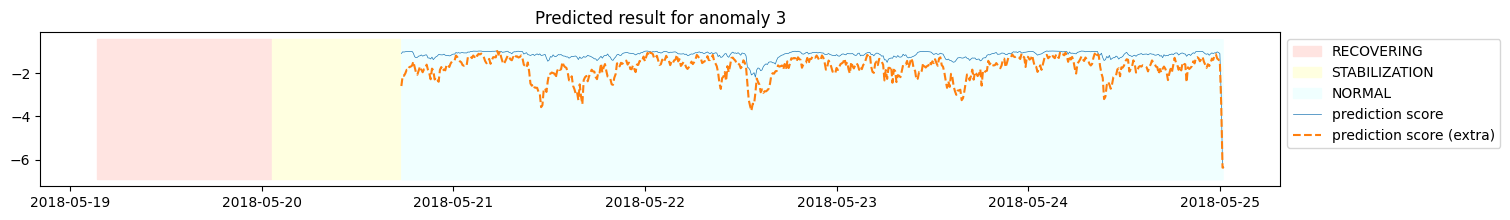

threshold: -1.5


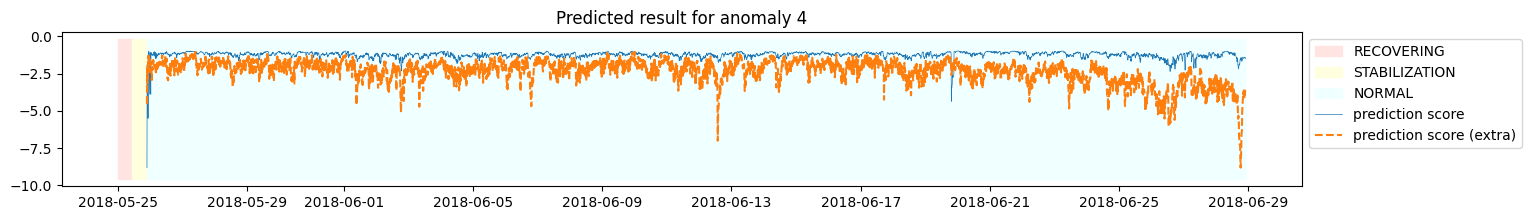

threshold: -1.5


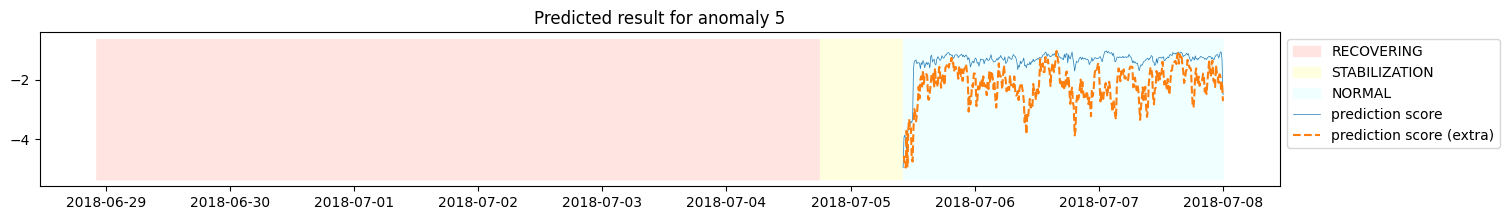

threshold: -1.5


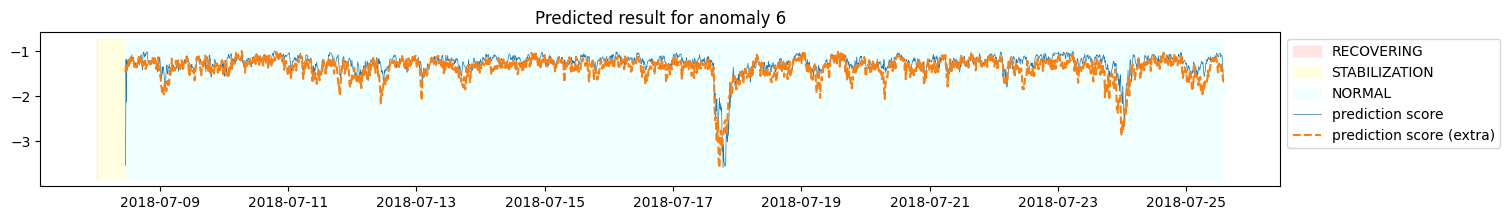

threshold: -1.5


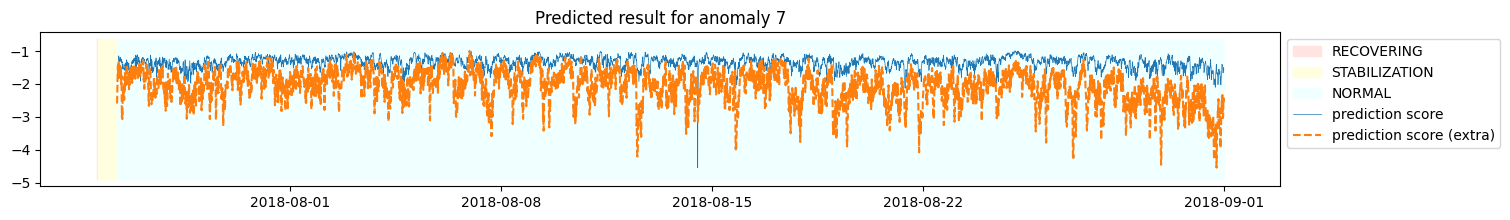

In [53]:
plot_predicted_results(
    predicted_lof_df,
    original_df=df,
    extra_result_df=predicted_isolationforest_df,
    threshold=-1.5
)

# ある時点の予測に影響度の高い特徴量の特定

In [54]:
broken_indices = df[df['machine_status'] == 'BROKEN'].index
indices = (
    pd.DatetimeIndex([df.index[0]])
    .append(broken_indices)
    .append(pd.DatetimeIndex([df.index[-1]]))
)

## Isolation Forest

In [55]:
def calc_influence_score(df, original_df, score_func):
    score = score_func(df)

    assert len(df) == 1

    result_df = pd.DataFrame(index=df.describe().columns.tolist())
    new_scores = []
    np.random.seed(1234)
    for col in df.describe().columns:
        u_limit = original_df[col].max()
        l_limit = original_df[col].min()
        random_values = np.random.uniform(l_limit, u_limit, 100)
        new_df = pd.concat([df] * 100, ignore_index=True)
        new_df[col] = random_values
        new_scores.append(score_func(new_df).mean())

    result_df["score"] = new_scores - score
    result_df = result_df.sort_values("score")

    print("5 features with the largest negative influence at the moment")
    display(result_df.head())
    
    print("5 features with the largest positive influence at the moment")
    display(result_df.tail())


In [56]:
for i in range(len(indices) - 1):
    # 期間内のスコアが最小の時点
    idx = predicted_isolationforest_df.loc[
        (indices[i] < predicted_isolationforest_df.index) &
        (predicted_isolationforest_df.index < indices[i + 1]),
        'score'
    ].idxmin()

    display(Markdown(f"### Period {i}"))
    print("Moment of lowest score")
    display(predicted_isolationforest_df.loc[[idx]])

    calc_influence_score(
        df=features_df.loc[[idx]],
        original_df=features_df,
        score_func=pipeline_isolationforest.decision_function,
    )

### Period 0

Moment of lowest score


,predicted,score
2018-04-06 03:50:00,1.0,0.028812


5 features with the largest negative influence at the moment


,score
s07,-0.010869
s12,-0.007219
"diff(s00,3)",-0.006851
"mm(diff(s02,3),12)",-0.006150
"mm(diff(s00,3),6)",-0.006075


5 features with the largest positive influence at the moment


,score
"diff(s09,12)",0.002711
"diff(s13,12)",0.002845
"mm(diff(s09,1),6)",0.003096
"mm(diff(s07,6),18)",0.003162
"mm(diff(s09,3),3)",0.004000


### Period 1

Moment of lowest score


,predicted,score
2018-04-15 10:30:00,1.0,0.039711


5 features with the largest negative influence at the moment


,score
"lag(s11,1)",-0.012013
s07,-0.010201
s14,-0.008585
s11,-0.007963
"mm(diff(s03,1),3)",-0.007701


5 features with the largest positive influence at the moment


,score
"diff(s05,18)",0.004062
"mm(diff(s14,6),18)",0.004095
"mm(diff(s06,3),3)",0.004112
"diff(s05,12)",0.004490
"mm(diff(s05,3),18)",0.006410


### Period 2

Moment of lowest score


,predicted,score
2018-05-02 09:50:00,1.0,0.004147


5 features with the largest negative influence at the moment


,score
"lag(s00,1)",-0.011813
s07,-0.010336
s11,-0.007807
"mm(diff(s07,1),3)",-0.007208
"mm(diff(s08,3),3)",-0.006689


5 features with the largest positive influence at the moment


,score
"mm(diff(s10,3),3)",0.002993
"mm(diff(s10,6),6)",0.003671
"mm(diff(s15,1),6)",0.003691
"mm(diff(s06,3),3)",0.004945
s05,0.005048


### Period 3

Moment of lowest score


,predicted,score
2018-05-25 00:20:00,-1.0,-0.031325


5 features with the largest negative influence at the moment


,score
"lag(s00,1)",-0.013367
"lag(s11,1)",-0.008630
"mm(diff(s00,6),12)",-0.006047
"mm(diff(s00,3),3)",-0.005891
"mm(diff(s10,3),6)",-0.005655


5 features with the largest positive influence at the moment


,score
"mm(diff(s09,1),3)",0.004354
"diff(s08,1)",0.004904
"diff(s08,6)",0.005020
"diff(s09,1)",0.005811
"diff(s10,1)",0.007159


### Period 4

Moment of lowest score


,predicted,score
2018-06-28 18:10:00,-1.0,-0.074964


5 features with the largest negative influence at the moment


,score
s12,-0.006066
"mm(diff(s00,1),12)",-0.005877
"mm(diff(s09,3),6)",-0.005638
"mm(diff(s08,1),6)",-0.005348
"mm(diff(s10,1),12)",-0.004846


5 features with the largest positive influence at the moment


,score
s15,0.004213
s05,0.004718
"mm(diff(s12,3),12)",0.005395
"mm(diff(s07,6),12)",0.006236
"mm(diff(s01,3),6)",0.007765


### Period 5

Moment of lowest score


,predicted,score
2018-07-05 10:40:00,1.0,0.029187


5 features with the largest negative influence at the moment


,score
"lag(s00,1)",-0.012225
s07,-0.010323
"mm(diff(s02,3),12)",-0.008725
"diff(s14,18)",-0.007786
"mm(diff(s00,1),12)",-0.007256


5 features with the largest positive influence at the moment


,score
"mm(diff(s07,3),6)",0.003389
"mm(diff(s03,1),6)",0.004320
"diff(s08,6)",0.004354
"mm(diff(s15,3),3)",0.005592
"diff(s01,1)",0.006947


### Period 6

Moment of lowest score


,predicted,score
2018-07-17 17:10:00,-1.0,-0.137816


5 features with the largest negative influence at the moment


,score
"diff(s09,12)",-0.008147
"diff(s08,1)",-0.006678
"mm(diff(s09,1),3)",-0.006436
"mm(diff(s06,3),3)",-0.005885
"mm(diff(s10,1),12)",-0.005634


5 features with the largest positive influence at the moment


,score
"mm(diff(s00,1),3)",0.004098
"mm(diff(s09,1),12)",0.004110
"mm(diff(s00,3),6)",0.004937
"diff(s05,18)",0.005423
"mm(diff(s00,3),3)",0.006016


### Period 7

Moment of lowest score


,predicted,score
2018-08-31 18:00:00,-1.0,-0.042844


5 features with the largest negative influence at the moment


,score
s12,-0.010924
s07,-0.008625
"mm(diff(s08,1),6)",-0.008065
"mm(diff(s07,3),3)",-0.007059
"lag(s00,1)",-0.006556


5 features with the largest positive influence at the moment


,score
"diff(s14,12)",0.002865
"mm(diff(s08,1),12)",0.002981
"mm(diff(s14,3),6)",0.003948
"mm(diff(s13,3),6)",0.004459
"mm(diff(s14,1),6)",0.004725


In [57]:
pipeline_lofn = create_pipeline(
    anomaly_detector=LocalOutlierFactor(
        # n_neighbors=20,
        # contamination=1/(6*24),  # 1日に1回程度
        novelty=True
    ),
    numeric_feature_names=ndf.columns.tolist()
)

NameError: name 'ndf' is not defined

In [ ]:
pipeline_lofn.fit(ndf)

In [ ]:
predicted_lofn_df = predict(
    features_df,
    predicted_func=pipeline_lofn.predict,
    score_func=pipeline_lofn.decision_function,
)

In [ ]:
plot_predicted_results(predicted_lofn_df, original_df=df, sensor_id="s00")